In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import seaborn as sns
import mapclassify as mc
import matplotlib.pyplot as plt
import folium

import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [2]:
# sns.set_style('white')
sns.set_style('darkgrid')
sns.set_context("paper", font_scale = 1)

plt.rc('font', family='serif')

plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', title_fontsize='small', fontsize='small')


plt.rcParams['svg.fonttype'] = 'none'

In [34]:
dataset = pd.read_pickle('../../geodata/results/01_master_building_dataset.pkl')
ch_g2g18  = gpd.read_file('../../geodata/ch_districts/ch_districts_g2g18.gpkg')
ch_agglo = gpd.read_file('../../geodata/ch_agglo/swiss_urban_agglomerations.gpkg')
ch_muni  = gpd.read_file('../../geodata/ch_gemeindetypen/ch_gemeindetypen_00_merged.gpkg')
ch_land  = gpd.read_file('../../geodata/ch_landtypo/landschaftstypen_2056.gpkg')
ch_income  = gpd.read_file('../../geodata/ch_districts/ch_income_per_commune_2018.gpkg')
# ch_g2g18  = gpd.read_file('../../../geodata/ch_districts/ch_districts_g2g18.gpkg')


In [128]:
maxvsh_cols    = dataset.columns[dataset.columns.str.contains('maxvsh')].tolist()
maxvsh_cols.remove('maxvsh_Sie9')
vaccess_cols   = dataset.columns[dataset.columns.str.contains('vwa')].tolist()
# mean_cols      = dataset.columns[dataset.columns.str.contains('mn')].tolist()
dist_cols      = dataset.columns[dataset.columns.str.contains('sum_')].tolist()
vconfig_cols   = np.setdiff1d(dataset.columns[np.where(dataset.columns == 'snt_0')[0][0]:np.where(dataset.columns == 'cmpx_gini')[0][0]+1].tolist(),dist_cols).tolist()[:-1]
id_cols        = ['ID_Geb','Stockwerk','FassPktX','FassPktY','FassPktZ']

dataset['unit_pano'] = dataset['unit_pano'].fillna(0)

In [270]:
grp = dataset.groupby('Agglo_Name')[maxvsh_cols]

scarce_maxvsh = np.array(maxvsh_cols)[(grp.median().round(0)==0).all()].tolist()
abund_maxvsh = np.array(maxvsh_cols)[~(grp.median().round(0)==0).all()].tolist()

In [272]:
sel_10agglo_lst = dataset.groupby(['Agglo_Name','Rich_Nabr'])['GMDNR'].size().unstack().sort_values(by = 'R', ascending = False).head(10).index.tolist()+['Rural']


In [273]:
rename_col = {
       'Dac1' :'Roof', 
       'Fas2' :'Fassade',  
       'Geb12':'Building',  
       'Kue8' :'Artificial Grass',  
       'Nat3' :'Nature',  
       'Veg3' :'Roof', 
       'Ver6' :'Road Traffic', 
       'sky'  :'Sky', 
       'Abb7' :'Industrial', 
       'Abw14':'Waste Waster', 
       'Flu18':'Airfield',
       'Ueb5' :'Other', 
       'Gew1' :'Water Bodies',  
       'Hel19':'Heliport', 
       'Keh15':'Waste Incineration',  
       'Lan10':'Agriculture', 
       'Lan17':'Airport', 
       'Sak13':'Sacral',  
       'Sie9' :'Settlement', 
       'Ver11':'High-Performing Traffic',  
       'Was16':'Water Basin',  
       'Fer3':'Far Dist. (1km - 50km)',
       'Mit2':'Mid Dist. (100m - 1km)',
       'Nah1':'Near Dist. (< 100m)',
       'Une4':'Infinite Dist. (> 50km)',
       'Sky': 'Sky',
       'cmpx_gini': 'Element Inequality - Gini',
       'cmpx_rh':'Element Richness',
       'cmpx_shanon':'Element Balance - Shanon',
       'dist_gini':'Distance Inequality - Gini',
       'pano_rich':'Panoramic Richness',
       'pano_sum':'Panoramic Share',
       'refuge' : 'Refuge',
       'rh_snt_0':'Neutral Sentiment',
       'rh_snt_Neg':'Negative Sentiment',
       'rh_snt_Pos':'Positive Sentiment',
       'snt_0': 'Neutral Sentiment',
       'snt_Neg':'Negative Sentiment',
       'snt_Pos':'Positive Sentiment',
       'Gürtel der Grosszentren':'', 
       'Grosszentren':'Major centers',
       'Gürtel der Mittelzentren':'Belt of medium centers', 
       'Nebenzentren der Grosszentren':'Secondary centers of large centers',
       'Periurbane ländliche Gemeinden':'Periurban rural communities', 
       'Mittelzentren':'Medium centers',
       'Touristische Gemeinden':'Tourist municipalities', 
       'Agrargemeinden':'Agricultural communities', 
       'Kleinzentren': 'Small centers' ,
       'Faltenjura':'Jura mountains', 
       'Taflejura':'Taflejura', 
       'Mittelland':'Midland', 
       'Alpenraum':'Alpine region', 
       'unabhängig':'Independent'
}

In [274]:
import seaborn as sns

In [161]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [308]:
def plotLolli(tgt, sel_cols, dat, scale, metric, pal, ax, l):
    dat.columns = dat.columns.str.replace('maxvsh_', '')
    dat.columns = dat.columns.str.replace('sum_Sh', '')
    if scale == 'standard':
        dat[sel_cols] = StandardScaler().fit_transform(dat[sel_cols])

    dat = dat.rename(columns = rename_col)
    grp = dat.melt(id_vars = tgt)
    
    if metric == 'median':
        grp = grp.groupby([tgt,'variable']).median().reset_index()#.pivot(index = tgt, columns = 'variable', values = 'value')
    
    elif metric == 'prop':
        grp = grp.groupby([tgt,'variable']).apply(lambda x: np.mean(x > 0)).reset_index()

    return sns.stripplot(data = grp, y = 'variable', x = 'value', hue = tgt, palette = pal, ax = ax, legend = l)



In [302]:
dat_agglo = dataset.query('Agglo_Name in @sel_10agglo_lst')

C:\Users\swietek\AppData\Local\Temp\ipykernel_13860\3848639019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[sel_cols] = StandardScaler().fit_transform(dat[sel_cols])


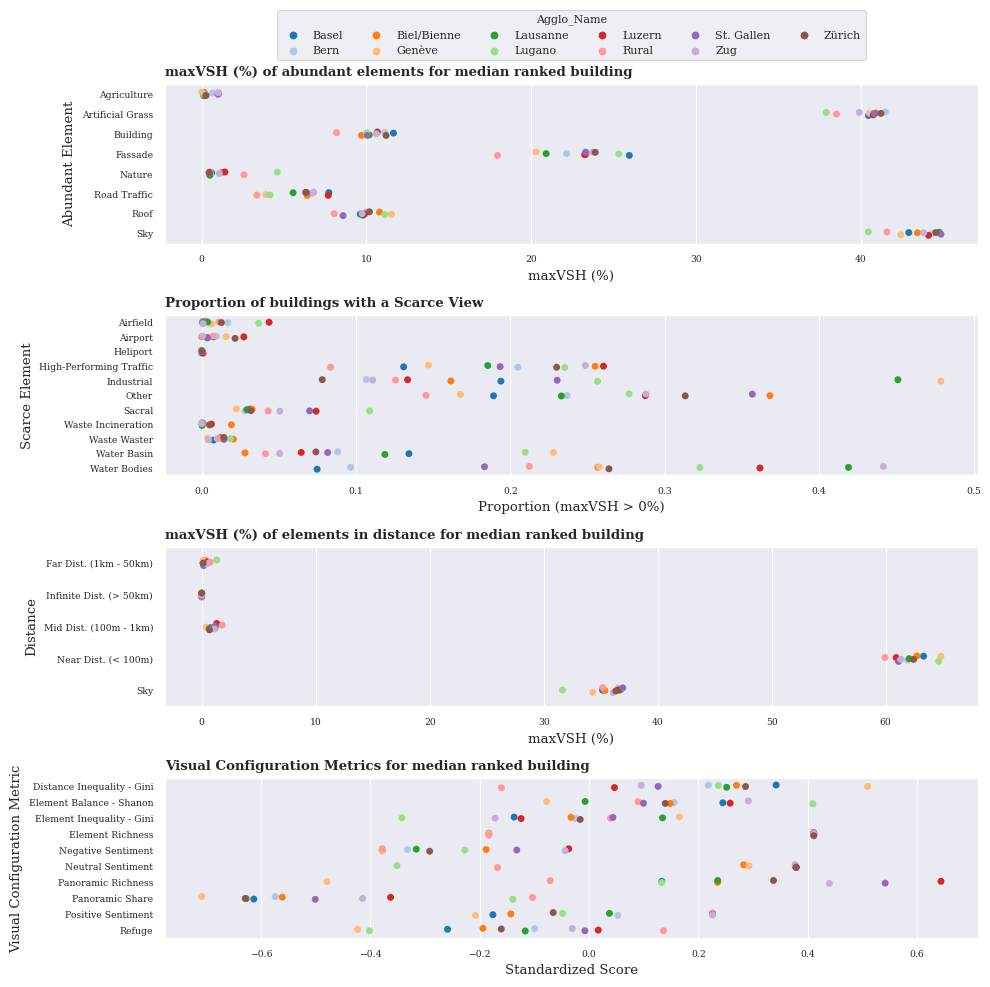

In [317]:
f, ax  = plt.subplots(4,1, figsize = (10,10))

plotLolli(tgt = 'Agglo_Name', sel_cols = abund_maxvsh, scale = 'none',
        dat = dat_agglo[['Agglo_Name'] + abund_maxvsh], 
        metric = 'median', pal = 'tab20', ax = ax[0], l = True)

ax[0].set_xlabel('maxVSH (%)'),ax[0].set_ylabel('Abundant Element'),
ax[0].set_title('maxVSH (%) of abundant elements for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = 'Agglo_Name', sel_cols = scarce_maxvsh, scale = 'none',
        dat = dat_agglo[['Agglo_Name'] + scarce_maxvsh], 
        metric = 'prop', pal = 'tab20', ax = ax[1], l = False)

ax[1].set_xlabel('Proportion (maxVSH > 0%)'),ax[1].set_ylabel('Scarce Element'),
ax[1].set_title('Proportion of buildings with a Scarce View', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = 'Agglo_Name', sel_cols = dist_cols, scale = 'none',
        dat = dat_agglo[['Agglo_Name'] + dist_cols], 
        metric = 'median', pal = 'tab20', ax = ax[2], l = False)

ax[2].set_xlabel('maxVSH (%)'), ax[2].set_ylabel('Distance'),   
ax[2].set_title('maxVSH (%) of elements in distance for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = 'Agglo_Name', sel_cols = vconfig_cols, scale = 'standard',
        dat = dat_agglo[['Agglo_Name'] + vconfig_cols], 
        metric = 'median', pal = 'tab20', ax = ax[3], l = False)

ax[3].set_xlabel('Standardized Score'), ax[3].set_ylabel('Visual Configuration Metric')
ax[3].set_title('Visual Configuration Metrics for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

sns.move_legend(ax[0], "upper center", bbox_to_anchor=(0.5, 1.5), ncols = 6)

plt.tight_layout()

plt.savefig('../../figs/viewmetric_agglo_summary_stripplot.png', dpi = 300, bbox_inches = 'tight')

In [318]:
ch_geme = gpd.read_file('../../geodata/ch_gemeindetypen/ch_gemeindetypen_00_merged.gpkg')

dat_ = gpd.sjoin(left_df = dataset.drop(columns = 'NAME'), right_df=ch_geme[['NAME','geometry']], how = 'left', op = 'within')

dat_['NAME'] = dat_['NAME'].map(rename_col).fillna('Other')
dat_ = dat_.query('NAME != "Other"')

C:\Users\swietek\AppData\Local\Temp\ipykernel_13860\3848639019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[sel_cols] = StandardScaler().fit_transform(dat[sel_cols])


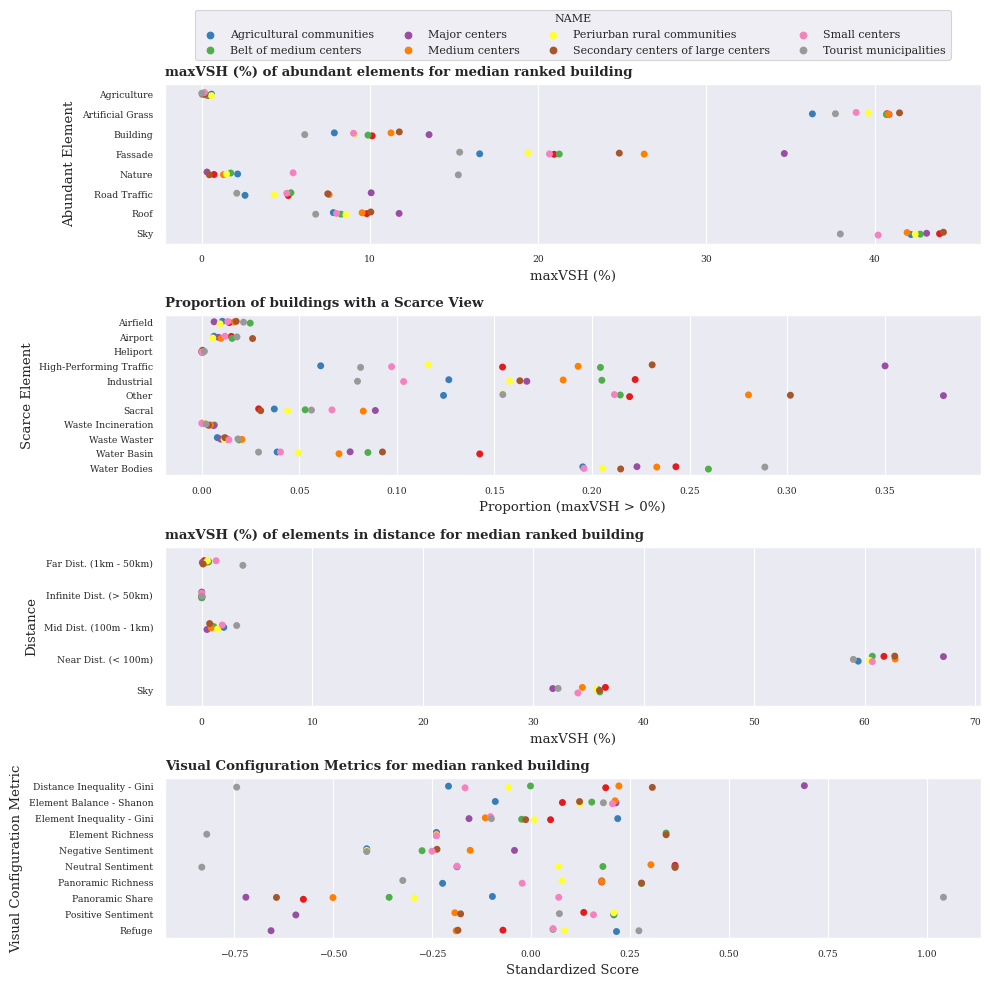

In [320]:
f, ax  = plt.subplots(4,1, figsize = (10,10))

tgt = 'NAME'
pal = 'Set1'


plotLolli(tgt = tgt, sel_cols = abund_maxvsh, scale = 'none',
        dat = dat_[[tgt] + abund_maxvsh], 
        metric = 'median', pal = pal, ax = ax[0], l = True)

ax[0].set_xlabel('maxVSH (%)'),ax[0].set_ylabel('Abundant Element'),
ax[0].set_title('maxVSH (%) of abundant elements for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = tgt, sel_cols = scarce_maxvsh, scale = 'none',
        dat = dat_[[tgt] + scarce_maxvsh], 
        metric = 'prop', pal = pal, ax = ax[1], l = False)

ax[1].set_xlabel('Proportion (maxVSH > 0%)'),ax[1].set_ylabel('Scarce Element'),
ax[1].set_title('Proportion of buildings with a Scarce View', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = tgt, sel_cols = dist_cols, scale = 'none',
        dat = dat_[[tgt] + dist_cols], 
        metric = 'median', pal = pal, ax = ax[2], l = False)

ax[2].set_xlabel('maxVSH (%)'), ax[2].set_ylabel('Distance'),   
ax[2].set_title('maxVSH (%) of elements in distance for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = tgt, sel_cols = vconfig_cols, scale = 'standard',
        dat = dat_[[tgt] + vconfig_cols], 
        metric = 'median', pal = pal, ax = ax[3], l = False)

ax[3].set_xlabel('Standardized Score'), ax[3].set_ylabel('Visual Configuration Metric')
ax[3].set_title('Visual Configuration Metrics for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

sns.move_legend(ax[0], "upper center", bbox_to_anchor=(0.5, 1.5), ncols = 4)

plt.tight_layout()

plt.savefig('../../figs/viewmetric_GEME_summary_stripplot.png', dpi = 300, bbox_inches = 'tight')

In [321]:
ch_land = gpd.read_file('../../geodata/ch_landtypo/landschaftstypen_2056.gpkg')
dat_ = gpd.sjoin(left_df = dataset, right_df=ch_land[['REGNAME_DE','geometry']], how = 'left', op = 'within')

dat_['REGNAME_DE'] = dat_['REGNAME_DE'].map(rename_col).fillna('Other')
dat_ = dat_.query('REGNAME_DE != "Other"')

C:\Users\swietek\AppData\Local\Temp\ipykernel_13860\3848639019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[sel_cols] = StandardScaler().fit_transform(dat[sel_cols])


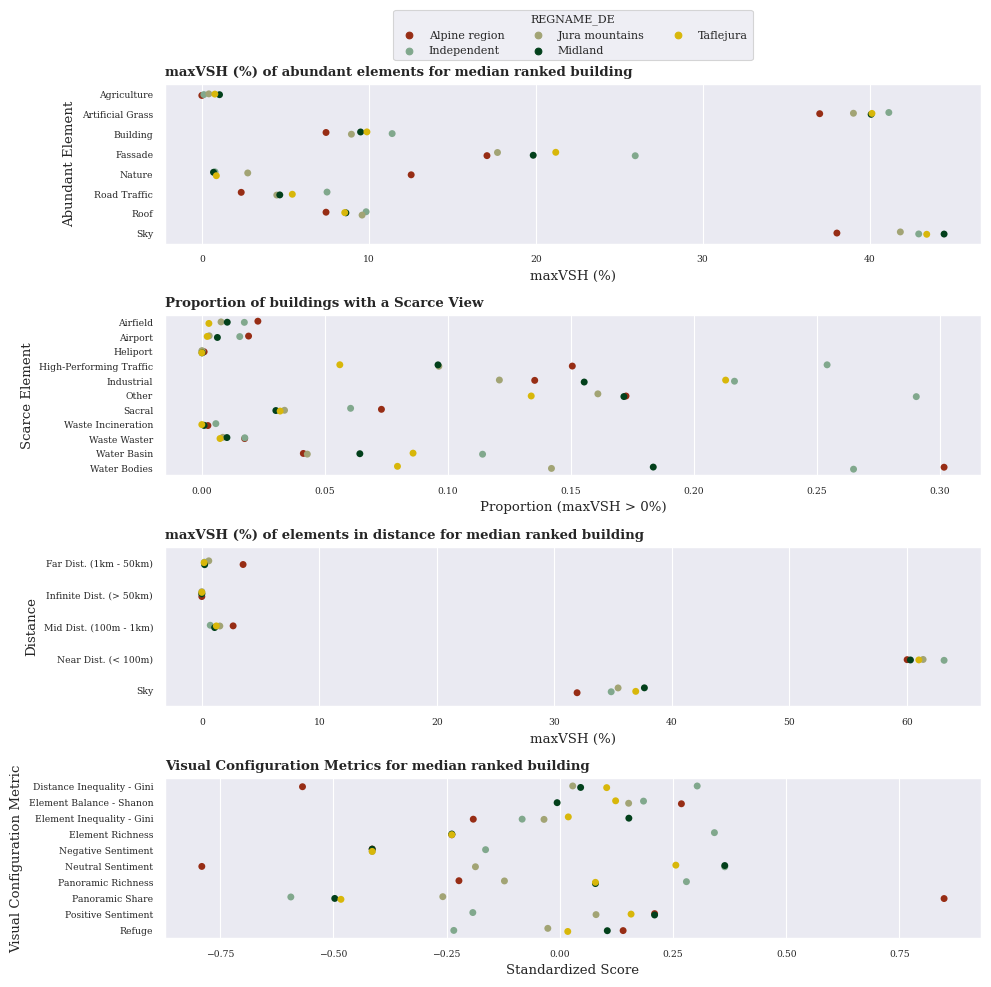

In [322]:
f, ax  = plt.subplots(4,1, figsize = (10,10))

tgt = 'REGNAME_DE'
pal = ["#D8B70A", "#02401B", "#A2A475", "#81A88D", "#972D15"][::-1]


plotLolli(tgt = tgt, sel_cols = abund_maxvsh, scale = 'none',
        dat = dat_[[tgt] + abund_maxvsh], 
        metric = 'median', pal = pal, ax = ax[0], l = True)

ax[0].set_xlabel('maxVSH (%)'),ax[0].set_ylabel('Abundant Element'),
ax[0].set_title('maxVSH (%) of abundant elements for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = tgt, sel_cols = scarce_maxvsh, scale = 'none',
        dat = dat_[[tgt] + scarce_maxvsh], 
        metric = 'prop', pal = pal, ax = ax[1], l = False)

ax[1].set_xlabel('Proportion (maxVSH > 0%)'),ax[1].set_ylabel('Scarce Element'),
ax[1].set_title('Proportion of buildings with a Scarce View', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = tgt, sel_cols = dist_cols, scale = 'none',
        dat = dat_[[tgt] + dist_cols], 
        metric = 'median', pal = pal, ax = ax[2], l = False)

ax[2].set_xlabel('maxVSH (%)'), ax[2].set_ylabel('Distance'),   
ax[2].set_title('maxVSH (%) of elements in distance for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

plotLolli(tgt = tgt, sel_cols = vconfig_cols, scale = 'standard',
        dat = dat_[[tgt] + vconfig_cols], 
        metric = 'median', pal = pal, ax = ax[3], l = False)

ax[3].set_xlabel('Standardized Score'), ax[3].set_ylabel('Visual Configuration Metric')
ax[3].set_title('Visual Configuration Metrics for median ranked building', x = 0, ha = 'left', fontweight = 'bold')

sns.move_legend(ax[0], "upper center", bbox_to_anchor=(0.5, 1.5), ncols = 3)

plt.tight_layout()

plt.savefig('../../figs/viewmetric_LANDTYP_summary_stripplot.png', dpi = 300, bbox_inches = 'tight')